<a href="https://colab.research.google.com/github/potuu/BreastCancerPredictionFromCsv/blob/main/Implementation_of_A_Domain_Generative_Graph_Network_for_EEG_Based_Emotion_Recognition_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Kütüphane ve Dosya Yükleme**

In [2]:
!pip install mne
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import mne
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.stats import zscore

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Dosya yolu
input_folder_path ="/content/drive/MyDrive/eeg_database_kou/processed_data"
# Dosya adları listesi oluştur
input_file_list = [os.path.join(input_folder_path, f"S{i}_processed_data.csv") for i in range(1, 41)]

In [5]:
eeg_data_path = input_file_list  # input_file_list içindeki dosya yollarını kullanarak

# Tüm CSV dosyalarını birleştirme
EEGdata = pd.concat([pd.read_csv(file) for file in eeg_data_path])

# Orijinal verideki EEG sinyallerinin sütun adlarını alma
eeg_columns = [col for col in EEGdata.columns if col.startswith('EEG')]

# EEG sinyallerini NumPy dizisine dönüştürme
eeg_data = EEGdata[eeg_columns].values

# Veriyi gösterme
EEGdata

,user_id,Timestamp,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,EEG.O2,EEG.P8,EEG.T8,EEG.FC6,EEG.F4,EEG.F8,EEG.AF4
0,7a4efc4f-6def-4ba3-a56d-672aec0fe324,2023-10-11 12:45:06.868602880+03:00,4020.000000,4268.205078,3799.487061,4109.743652,4105.641113,4109.230957,4060.512939,4056.923096,3908.718018,4536.410156,4517.948730,4373.333496,4124.615234,4655.384766
1,7a4efc4f-6def-4ba3-a56d-672aec0fe324,2023-10-11 12:45:06.876523008+03:00,4020.000000,4270.769043,3797.435791,4106.666504,4103.589844,4106.666504,4062.564209,4066.153809,3918.974365,4537.436035,4521.025879,4376.410156,4124.615234,4656.922852
2,7a4efc4f-6def-4ba3-a56d-672aec0fe324,2023-10-11 12:45:06.884342784+03:00,4012.307617,4265.641113,3790.256348,4101.025879,4103.077148,4102.563965,4069.743652,4071.281982,3922.051270,4534.871582,4515.897461,4373.846191,4119.487305,4648.205078
3,7a4efc4f-6def-4ba3-a56d-672aec0fe324,2023-10-11 12:45:06.892262912+03:00,4007.692383,4260.512695,3787.179443,4102.051270,4104.102539,4101.538574,4070.769287,4074.358887,3922.564209,4536.922852,4512.307617,4370.256348,4116.410156,4645.641113
4,7a4efc4f-6def-4ba3-a56d-672aec0fe324,2023-10-11 12:45:06.900082944+03:00,4011.794922,4262.051270,3789.230713,4105.641113,4104.102539,4100.512695,4068.718018,4076.410156,3924.615479,4538.461426,4518.461426,4373.333496,4118.461426,4651.282227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74235,4737537c-0a5d-46e2-9c1f-9872520872c4,2023-12-14 10:40:45.713638912+03:00,4040.512939,4265.128418,3771.794922,4127.179688,4115.897461,4181.538574,4122.563965,4127.179688,3935.384521,4653.333496,4491.282227,4543.077148,4137.436035,4623.589844
74236,4737537c-0a5d-46e2-9c1f-9872520872c4,2023-12-14 10:40:45.721458944+03:00,4037.435791,4256.410156,3759.487061,4126.153809,4114.871582,4184.102539,4136.410156,4126.666504,3927.179443,4656.922852,4490.769043,4545.641113,4142.051270,4616.410156
74237,4737537c-0a5d-46e2-9c1f-9872520872c4,2023-12-14 10:40:45.729278976+03:00,4047.179443,4254.358887,3761.538574,4122.051270,4098.974121,4187.692383,4136.922852,4138.974121,3924.102539,4648.205078,4490.256348,4552.307617,4137.436035,4618.461426
74238,4737537c-0a5d-46e2-9c1f-9872520872c4,2023-12-14 10:40:45.737097984+03:00,4055.384521,4255.384766,3766.153809,4120.000000,4094.358887,4177.948730,4124.102539,4144.102539,3925.641113,4643.589844,4491.282227,4552.820313,4133.846191,4624.102539


In [6]:
# Satır ve sütun sayısı
print("DataFrame'in satır ve sütun sayısı:", EEGdata.shape)

DataFrame'in satır ve sütun sayısı: (2969600, 16)


In [7]:
# Örnekleme frekansı
sfreq = 128  # Örneklem frekansı 128 Hz olarak güncellendi

# Kanal adlarını ve örnekleme frekansını içeren info yapısı oluşturun
info = mne.create_info(eeg_columns, sfreq=sfreq, ch_types='eeg')

# MNE RawArray oluşturun
raw = mne.io.RawArray(eeg_data.T, info)

Creating RawArray with float64 data, n_channels=14, n_times=2969600
    Range : 0 ... 2969599 =      0.000 ... 23199.992 secs
Ready.


In [8]:
#Dosya yolu
processed_label_path = "/content/drive/MyDrive/eeg_database_kou/label_processed_data.csv"

# CSV dosyasını semicolon ile ayrılmış şekilde okuma
processed_label = pd.read_csv(processed_label_path, sep=';')

# İlk 5 satırı görüntüleme
print(processed_label.head())


                                user_id  trail                  start_date  \
0  7a4efc4f-6def-4ba3-a56d-672aec0fe324      1  2023-10-11 12:45:06.863000   
1  7a4efc4f-6def-4ba3-a56d-672aec0fe324      2  2023-10-11 12:45:41.053000   
2  7a4efc4f-6def-4ba3-a56d-672aec0fe324      3  2023-10-11 12:46:15.225000   
3  7a4efc4f-6def-4ba3-a56d-672aec0fe324      4  2023-10-11 12:46:49.414000   
4  7a4efc4f-6def-4ba3-a56d-672aec0fe324      5  2023-10-11 12:47:33.596000   

                  finish_date  duration  val  aro  dom  
0  2023-10-11 12:45:35.888000        29    1    0    1  
1  2023-10-11 12:46:10.055000        29    0    1    1  
2  2023-10-11 12:46:44.240000        29    1    1    0  
3  2023-10-11 12:47:18.427000        29    0    1    1  
4  2023-10-11 12:48:02.605000        29    1    0    0  


In [9]:
# Satır ve sütun sayısını öğrenmek için shape özelliğini kullanalım
print(f"Satır ve sütun sayısı: {processed_label.shape}")

Satır ve sütun sayısı: (800, 8)


In [10]:
# EEG verilerini ve label dosyasını yükleyelim
EEGdata = pd.concat([pd.read_csv(file) for file in eeg_data_path])  # EEG verileri
processed_label = pd.read_csv(processed_label_path, sep=';')  # Label dosyası

# EEG verilerini trail numaralarına göre ayırma
eeg_data_sorted = EEGdata.sort_values(by=["user_id", "Timestamp"])  # Veriyi user_id ve Timestamp'e göre sıralama

# Trail başına 3712 satır olacak şekilde EEG verilerini etiketleme
eeg_data_sorted['trail'] = eeg_data_sorted.groupby('user_id').cumcount() // 3712 + 1

# Processed_label dosyasındaki val ve aro etiketlerini EEG verisine atama
# processed_label dosyasındaki trail'ler her bir user_id için 1-20 arası
merged_data = pd.merge(eeg_data_sorted, processed_label[['user_id', 'trail', 'val', 'aro']],
                       on=['user_id', 'trail'], how='left')

# Birleştirilmiş veriyi görüntüleyelim
print(merged_data.head())


                                user_id                            Timestamp  \
0  06f49575-a0ee-46fd-8d0d-4133886d62a5  2023-10-20 10:48:21.305135872+03:00   
1  06f49575-a0ee-46fd-8d0d-4133886d62a5  2023-10-20 10:48:21.312954880+03:00   
2  06f49575-a0ee-46fd-8d0d-4133886d62a5  2023-10-20 10:48:21.320774912+03:00   
3  06f49575-a0ee-46fd-8d0d-4133886d62a5  2023-10-20 10:48:21.328594944+03:00   
4  06f49575-a0ee-46fd-8d0d-4133886d62a5  2023-10-20 10:48:21.336414208+03:00   

       EEG.AF3       EEG.F7       EEG.F3      EEG.FC5       EEG.T7  \
0  3842.051270  4117.436035  3648.718018  4053.333252  3955.384521   
1  3837.435791  4111.282227  3649.743652  4049.743652  3955.384521   
2  3843.589844  4111.282227  3652.307617  4049.743652  3960.512939   
3  3854.871826  4117.436035  3655.384521  4055.897461  3963.589844   
4  3854.358887  4114.871582  3655.384521  4053.846191  3961.025635   

        EEG.P7       EEG.O1       EEG.O2       EEG.P8       EEG.T8  \
0  4114.871582  3984.615479 

In [11]:
# merged_data'nın satır ve sütun sayısını yazdırma
print("Satır sayısı:", merged_data.shape[0])
print("Sütun sayısı:", merged_data.shape[1])


Satır sayısı: 2969600
Sütun sayısı: 19


# **2. Veri Ön İşleme**

**Normalizasyon**:

EEG verileri Min-Max yöntemiyle [0, 1] aralığına getirilmiştir.

In [12]:
# NORMALLEŞTİRME VE NORMALLEŞTİRİLMİŞ VERİYİ GÖRÜNTÜLEME

# EEG sütunları
eeg_columns = [col for col in merged_data.columns if col.startswith('EEG')]

# Min-Max normalizasyonu fonksiyonu
def min_max_normalize(df, columns):
    for col in columns:
        col_min = df[col].min()
        col_max = df[col].max()
        # Min-Max normalizasyonu uygulama
        df[col] = (df[col] - col_min) / (col_max - col_min)
    return df

# merged_data üzerinde EEG verilerini normalleştirme
merged_data = min_max_normalize(merged_data, eeg_columns)

# Normalleştirilmiş veriyi gösterme
print(merged_data.head())


                                user_id                            Timestamp  \
0  06f49575-a0ee-46fd-8d0d-4133886d62a5  2023-10-20 10:48:21.305135872+03:00   
1  06f49575-a0ee-46fd-8d0d-4133886d62a5  2023-10-20 10:48:21.312954880+03:00   
2  06f49575-a0ee-46fd-8d0d-4133886d62a5  2023-10-20 10:48:21.320774912+03:00   
3  06f49575-a0ee-46fd-8d0d-4133886d62a5  2023-10-20 10:48:21.328594944+03:00   
4  06f49575-a0ee-46fd-8d0d-4133886d62a5  2023-10-20 10:48:21.336414208+03:00   

    EEG.AF3    EEG.F7    EEG.F3   EEG.FC5    EEG.T7    EEG.P7    EEG.O1  \
0  0.459204  0.492456  0.435114  0.487852  0.475901  0.482913  0.476901   
1  0.458636  0.491720  0.435241  0.487402  0.475901  0.483163  0.476712   
2  0.459393  0.491720  0.435561  0.487402  0.476541  0.483475  0.477215   
3  0.460781  0.492456  0.435945  0.488173  0.476926  0.483101  0.477467   
4  0.460718  0.492149  0.435945  0.487916  0.476606  0.482415  0.477027   

     EEG.O2    EEG.P8    EEG.T8   EEG.FC6    EEG.F4    EEG.F8   EEG.

**Band-Pass Filtreleme:**

EEG sinyalleri 0.5 Hz ile 50 Hz arasında band-pass filtresinden geçirilmiştir.

In [13]:
# BAND-PASS FİLTRELEME

def bandpass_filter(df, columns, lowcut=0.5, highcut=50.0, fs=500.0, order=5):
    """
    Band-pass filtreyi EEG verilerine uygular.

    Parameters:
    - df: EEG verilerini içeren DataFrame
    - columns: EEG verilerini içeren sütunlar
    - lowcut: Alt frekans sınırı (Hz)
    - highcut: Üst frekans sınırı (Hz)
    - fs: Örnekleme frekansı (Hz)
    - order: Filtrenin derecesi (genellikle 5)

    Returns:
    - df: Filtrelenmiş EEG verileri
    """
    nyquist = 0.5 * fs  # Nyquist frekansı
    low = lowcut / nyquist
    high = highcut / nyquist

    # Butterworth bandpass filtreyi tasarlama
    b, a = signal.butter(order, [low, high], btype='band')

    # Her EEG kanalına bandpass filtresi uygulama
    for col in columns:
        # Filtreyi uygulama
        df[col] = signal.filtfilt(b, a, df[col])

    return df


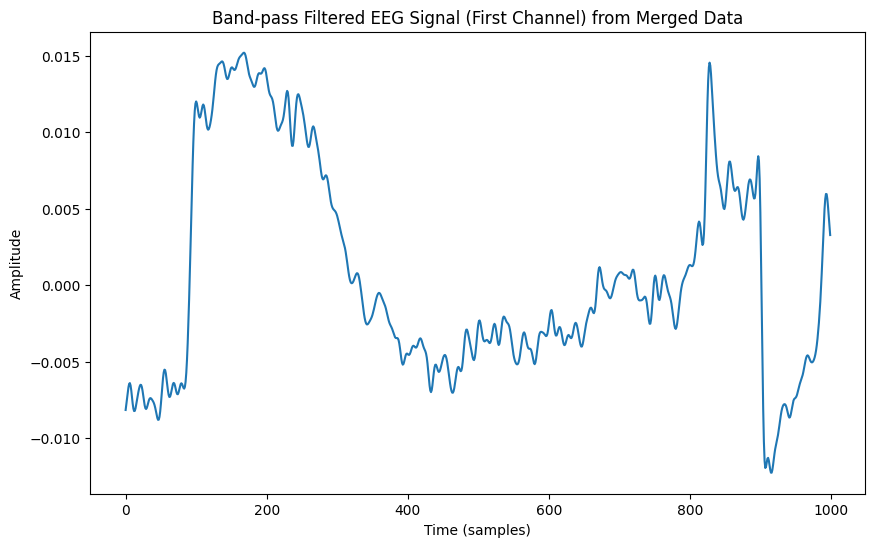

In [14]:
# BAND-PASS FİLTRELEME UYGULAMA VE UYGULAMA SONRASI GÖRÜNTÜLEME

# EEG sütunları
eeg_columns = [col for col in merged_data.columns if col.startswith('EEG')]

# merged_data üzerinde band-pass filtresi uygulama
merged_data_filtered = bandpass_filter(merged_data.copy(), eeg_columns, lowcut=0.5, highcut=50.0, fs=500.0, order=5)

# Filtrelenmiş veriyi görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(merged_data_filtered[eeg_columns[0]].head(1000))  # İlk 1000 veri noktasını görselleştirelim
plt.title("Band-pass Filtered EEG Signal (First Channel) from Merged Data")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()


**Aykırı Değerlerin Çıkarılması:**

Z-skor yöntemiyle aykırı değerler (threshold = 3.0) temizlenmiştir.

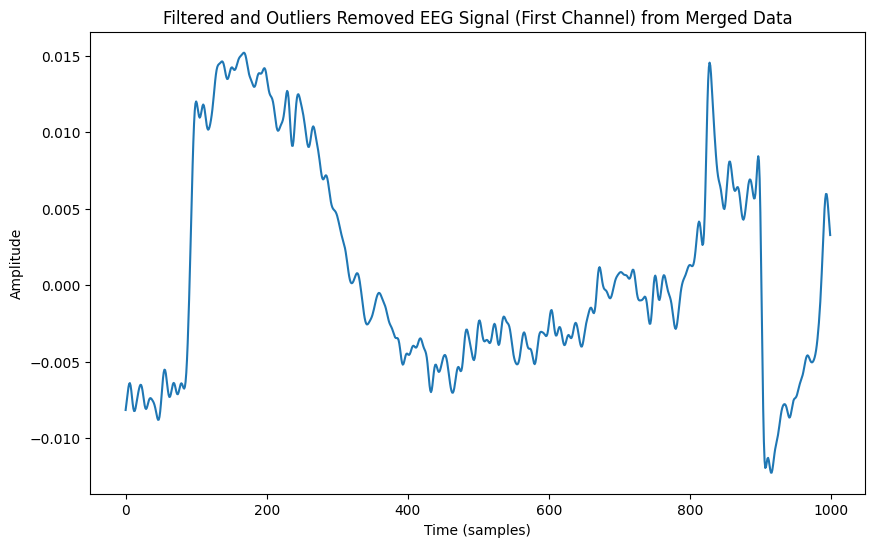

In [15]:
# AYKIRI DEĞERLERİ Z-SKORU İLE ELE ALINMASI

def remove_outliers(df, columns, threshold=3.0):
    for col in columns:
        z_scores = np.abs(zscore(df[col]))
        df = df[z_scores < threshold]
    return df

# EEG sütunları
eeg_columns = [col for col in merged_data.columns if col.startswith('EEG')]

# merged_data üzerindeki EEG verilerine band-pass filtresi uygulama (önceden yapılmıştı)
merged_data_filtered = bandpass_filter(merged_data.copy(), eeg_columns, lowcut=0.5, highcut=50.0, fs=500.0, order=5)

# Aykırı değerleri z-skoru ile ele alalım
merged_data_filtered_no_outliers = remove_outliers(merged_data_filtered, eeg_columns)

# Aykırı değerleri ele alınmış veriyi görselleştirelim
plt.figure(figsize=(10, 6))
plt.plot(merged_data_filtered_no_outliers[eeg_columns[0]].head(1000))  # İlk 1000 veri noktasını görselleştirelim
plt.title("Filtered and Outliers Removed EEG Signal (First Channel) from Merged Data")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()


In [16]:
print(merged_data_filtered_no_outliers)

                                      user_id  \
0        06f49575-a0ee-46fd-8d0d-4133886d62a5   
1        06f49575-a0ee-46fd-8d0d-4133886d62a5   
2        06f49575-a0ee-46fd-8d0d-4133886d62a5   
3        06f49575-a0ee-46fd-8d0d-4133886d62a5   
4        06f49575-a0ee-46fd-8d0d-4133886d62a5   
...                                       ...   
2969595  e8ece098-e9c6-41f6-b78d-d76ff89090aa   
2969596  e8ece098-e9c6-41f6-b78d-d76ff89090aa   
2969597  e8ece098-e9c6-41f6-b78d-d76ff89090aa   
2969598  e8ece098-e9c6-41f6-b78d-d76ff89090aa   
2969599  e8ece098-e9c6-41f6-b78d-d76ff89090aa   

                                   Timestamp   EEG.AF3    EEG.F7    EEG.F3  \
0        2023-10-20 10:48:21.305135872+03:00 -0.008158 -0.002182 -0.001672   
1        2023-10-20 10:48:21.312954880+03:00 -0.007779 -0.002269 -0.001404   
2        2023-10-20 10:48:21.320774912+03:00 -0.007391 -0.002379 -0.001160   
3        2023-10-20 10:48:21.328594944+03:00 -0.007008 -0.002533 -0.000961   
4        2023-10-20 1

In [17]:
merged_data_filtered_no_outliers.head()

,user_id,Timestamp,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,EEG.O2,EEG.P8,EEG.T8,EEG.FC6,EEG.F4,EEG.F8,EEG.AF4,trail,val,aro
0,06f49575-a0ee-46fd-8d0d-4133886d62a5,2023-10-20 10:48:21.305135872+03:00,-0.008158,-0.002182,-0.001672,-0.001752,-0.000834,-0.000903,-0.000642,-0.000739,-0.001045,0.009525,-0.000769,-0.000914,-0.001022,0.000155,1,1,0
1,06f49575-a0ee-46fd-8d0d-4133886d62a5,2023-10-20 10:48:21.312954880+03:00,-0.007779,-0.002269,-0.001404,-0.001742,-0.000555,-0.000927,-0.000645,-0.000611,-0.000932,0.009492,-0.000725,-0.000813,-0.000780,0.000328,1,1,0
2,06f49575-a0ee-46fd-8d0d-4133886d62a5,2023-10-20 10:48:21.320774912+03:00,-0.007391,-0.002379,-0.001160,-0.001733,-0.000347,-0.001014,-0.000654,-0.000500,-0.000852,0.009441,-0.000622,-0.000679,-0.000521,0.000538,1,1,0
3,06f49575-a0ee-46fd-8d0d-4133886d62a5,2023-10-20 10:48:21.328594944+03:00,-0.007008,-0.002533,-0.000961,-0.001732,-0.000262,-0.001200,-0.000670,-0.000416,-0.000827,0.009360,-0.000427,-0.000495,-0.000241,0.000802,1,1,0
4,06f49575-a0ee-46fd-8d0d-4133886d62a5,2023-10-20 10:48:21.336414208+03:00,-0.006673,-0.002750,-0.000825,-0.001754,-0.000322,-0.001481,-0.000681,-0.000355,-0.000867,0.009252,-0.000143,-0.000272,0.000041,0.001106,1,1,0


# **3. Veri Seti Ayırımı**

Veriler %80 eğitim (%20 doğrulama) olacak şekilde bölünmüştür.

Veriler PyTorch formatına dönüştürülmüş, ardından DataLoader ile mini-batch'ler halinde hazırlanmıştır.
Eğitim: train_loader
Doğrulama: val_loader

In [18]:
# Eğitim için veri hazırlığı (filtered veri için)
# Eğitim ve doğrulama setlerine ayırma
X_train, X_val, y_train, y_val = train_test_split(merged_data_filtered_no_outliers[eeg_columns].values,
                                                  merged_data_filtered_no_outliers['val'].values,
                                                  test_size=0.2, random_state=42)

# Veriyi Tensor formatına dönüştürme
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Sınıf etiketleri için long
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# DataLoader oluşturma
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# **4. Model Mimarileri**

**Binary Classification Modeli**

Katmanlar:

Fully Connected (Giriş -> Gizli Katman, 128 nöron)

ReLU Aktivasyonu

Fully Connected (Gizli -> 64 nöron)

ReLU Aktivasyonu

Fully Connected (64 -> 1 nöron)

Sigmoid Aktivasyonu (Binary sınıflandırma için)

In [19]:
# Modelin Binary Classification için çıkışı 2 sınıf olacak şekilde tanımlanması
class EEGBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EEGBinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size // 2, 1)  # Single output for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return self.sigmoid(x)  # Sigmoid for binary classification


**Multiclass Classification Modeli**


Katmanlar:

Fully Connected (Giriş -> Gizli Katman, 128 nöron)

ReLU Aktivasyonu

Fully Connected (Gizli -> 64 nöron)

ReLU Aktivasyonu

Fully Connected (64 -> 4 nöron)

Softmax Aktivasyonu (Çok sınıflı sınıflandırma için)

In [20]:
# Modelin Multiclass Classification için çıkışı 4 sınıf olacak şekilde tanımlanması
class EEGMulticlassClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=4):
        super(EEGMulticlassClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size // 2, output_size)  # 4 sınıf için output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return self.softmax(x)  # Softmax for multiclass classification


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def binary_classification_train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        all_train_labels = []
        all_train_preds = []

        # Eğitim verileri üzerinde iterasyon
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())  # Squeeze to match output dimension
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()  # Binary prediction threshold at 0.5
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_predictions / total_predictions
        train_precision = precision_score(all_train_labels, all_train_preds)
        train_recall = recall_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds)

        # Doğrulama
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0
        all_val_labels = []
        all_val_preds = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_predictions += labels.size(0)

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct_predictions / val_total_predictions
        val_precision = precision_score(all_val_labels, all_val_preds)
        val_recall = recall_score(all_val_labels, all_val_preds)
        val_f1 = f1_score(all_val_labels, all_val_preds)

        # Epoch başına yazdırma
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%, '
              f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%, '
              f'Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1: {val_f1:.4f}')


In [22]:
def multiclass_classification_train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        all_train_labels = []
        all_train_preds = []

        # Eğitim verileri üzerinde iterasyon
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Multiclass için en yüksek sınıfı al
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_predictions / total_predictions
        train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
        train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

        # Doğrulama
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0
        all_val_labels = []
        all_val_preds = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_predictions += labels.size(0)

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct_predictions / val_total_predictions
        val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
        val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

        # Epoch başına yazdırma
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%, '
              f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%, '
              f'Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1: {val_f1:.4f}')


# **5. Eğitim ve Değerlendirme**

Kayıp Fonksiyonu: BCEWithLogitsLoss (Binary sınıflandırma için).

Optimizasyon: Adam optimizatörü (lr=0.001).

Eğitim boyunca precision, recall, F1, ve doğruluk hesaplanır.

In [23]:
# Binary Classification için model seçimi
binary_model = EEGBinaryClassifier(input_size=X_train.shape[1], hidden_size=128)
criterion = nn.BCEWithLogitsLoss()  # Binary classification için uygun kayıp fonksiyonu
optimizer = optim.Adam(binary_model.parameters(), lr=0.001)

binary_classification_train(binary_model, train_loader, val_loader, criterion, optimizer, num_epochs=100)


Epoch [1/100], Train Loss: 0.6914, Train Accuracy: 47.14%, Train Precision: 0.5946, Train Recall: 0.0001, Train F1: 0.0003, Validation Loss: 0.6909, Validation Accuracy: 47.18%, Validation Precision: 0.7224, Validation Recall: 0.0016, Validation F1: 0.0032
Epoch [2/100], Train Loss: 0.6907, Train Accuracy: 47.37%, Train Precision: 0.6511, Train Recall: 0.0094, Train F1: 0.0185, Validation Loss: 0.6915, Validation Accuracy: 47.77%, Validation Precision: 0.6240, Validation Recall: 0.0307, Validation F1: 0.0585
Epoch [3/100], Train Loss: 0.6900, Train Accuracy: 47.72%, Train Precision: 0.6485, Train Recall: 0.0241, Train F1: 0.0465, Validation Loss: 0.6898, Validation Accuracy: 48.45%, Validation Precision: 0.6297, Validation Recall: 0.0610, Validation F1: 0.1112
Epoch [4/100], Train Loss: 0.6893, Train Accuracy: 48.07%, Train Precision: 0.6491, Train Recall: 0.0384, Train F1: 0.0725, Validation Loss: 0.6887, Validation Accuracy: 48.28%, Validation Precision: 0.6567, Validation Recall: 0.

Kayıp Fonksiyonu: CrossEntropyLoss (Çok sınıflı sınıflandırma için).

Optimizasyon: Adam optimizatörü (lr=0.001).

Eğitim boyunca aynı metrikler hesaplanır (weighted average ile).

In [24]:

# Multiclass Classification için model seçimi
multiclass_model = EEGMulticlassClassifier(input_size=X_train.shape[1], hidden_size=128, output_size=4)
criterion = nn.CrossEntropyLoss()  # Multiclass için uygun kayıp fonksiyonu
optimizer = optim.Adam(multiclass_model.parameters(), lr=0.001)

multiclass_classification_train(multiclass_model, train_loader, val_loader, criterion, optimizer, num_epochs=100)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/100], Train Loss: 1.1642, Train Accuracy: 52.84%, Train Precision: 0.5002, Train Recall: 0.5284, Train F1: 0.3675, Validation Loss: 1.1630, Validation Accuracy: 52.87%, Validation Precision: 0.2796, Validation Recall: 0.5287, Validation F1: 0.3657
Epoch [2/100], Train Loss: 1.1619, Train Accuracy: 53.04%, Train Precision: 0.5245, Train Recall: 0.5304, Train F1: 0.4078, Validation Loss: 1.1601, Validation Accuracy: 53.39%, Validation Precision: 0.5369, Validation Recall: 0.5339, Validation F1: 0.4214
Epoch [3/100], Train Loss: 1.1601, Train Accuracy: 53.38%, Train Precision: 0.5281, Train Recall: 0.5338, Train F1: 0.4615, Validation Loss: 1.1589, Validation Accuracy: 53.68%, Validation Precision: 0.5412, Validation Recall: 0.5368, Validation F1: 0.4378
Epoch [4/100], Train Loss: 1.1589, Train Accuracy: 53.58%, Train Precision: 0.5305, Train Recall: 0.5358, Train F1: 0.4787, Validation Loss: 1.1591, Validation Accuracy: 53.64%, Validation Precision: 0.5526, Validation Recall: 0.

# **6. Confusion Matrix**

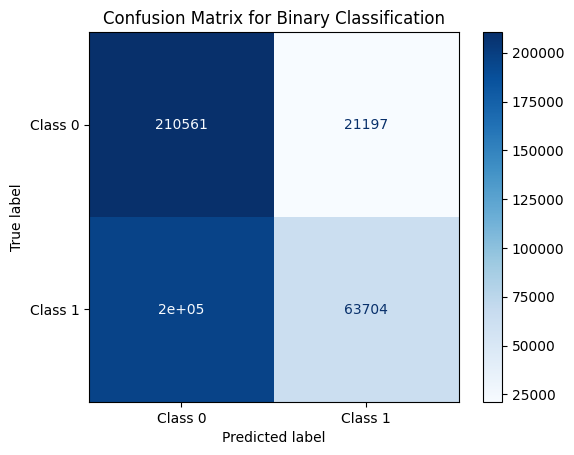

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix hesaplama
y_val_preds_binary = []
y_val_labels_binary = []

binary_model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = binary_model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        y_val_preds_binary.extend(predicted.cpu().numpy())
        y_val_labels_binary.extend(labels.cpu().numpy())

# Confusion matrix'i çizdirme
cm = confusion_matrix(y_val_labels_binary, y_val_preds_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Binary Classification")
plt.show()


# **7. Modelin Mimari Şeması**

***Binary Model***

Input Layer (n_features)

    ↓

Fully Connected Layer (128 nöron) → ReLU

    ↓

Fully Connected Layer (64 nöron) → ReLU

    ↓
    
Fully Connected Layer (1 nöron) → Sigmoid


***Multiclass Model***

Input Layer (n_features)

    ↓

Fully Connected Layer (128 nöron) → ReLU

    ↓

Fully Connected Layer (64 nöron) → ReLU

    ↓
    
Fully Connected Layer (4 nöron) → Softmax
